# 2.0.2 Generating Fractal Embeddings

Creating the embeddings for the fractal images.

## Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [4]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and other non-code related info
%watermark -n -m -g -b -t -h

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Wed Aug 19 2020 12:29:48 

compiler   : GCC 7.3.0
system     : Linux
release    : 5.4.0-42-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
host name  : apra-x3
Git hash   : 9dcef66145f8f506529041f0eb7a84a740a26a16
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [5]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [6]:
# Set the matplotlib mode
%matplotlib inline

## Imports

In [79]:
from pathlib import Path

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image, ImageOps
from torchvision.transforms import transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, IterableDataset, DataLoader

%aimport prevseg.constants
import prevseg.constants as const
%aimport prevseg.index
import prevseg.index as index
%aimport prevseg.schapiro
from prevseg.schapiro import walk, graph

# Keep track of versions of everything
%watermark -v -iv

networkx    2.4
PIL.Image   7.2.0
prevseg     0+untagged.32.g9dcef66.dirty
numpy       1.19.1
torch       1.6.0
torchvision 0.7.0
CPython 3.8.5
IPython 7.16.1


## Image Sizes

Resnets tend to require 224x224, images are 128x128

### Load and Resize

In [17]:
EMBED_SHAPE = (224,224)

In [49]:
assert index.DIR_SCH_FRACTALS.exists()
paths_fractals = list(index.DIR_SCH_FRACTALS.iterdir())
list_fractals = [Image.open(str(path)).resize(EMBED_SHAPE)
                 for path in paths_fractals]
_ = [img.load() for img in list_fractals]

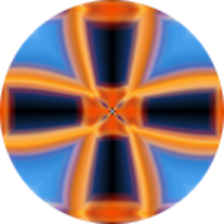

In [53]:
list_fractals[0]

In [66]:
np.array(list_fractals[0]).shape

(224, 224, 4)

### Remove Alpha Channel

See [this](https://stackoverflow.com/questions/9166400/convert-rgba-png-to-rgb-with-pil) post.

In [63]:
list_fractals_no_alpha = [Image.new("RGB", EMBED_SHAPE, (0,0,0))
                          for _ in range(len(list_fractals))]
_ = [bk.paste(img, mask=img.split()[3]) for bk, img in zip(list_fractals_no_alpha, 
                                                           list_fractals)]

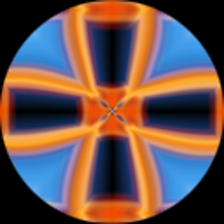

In [64]:
list_fractals_no_alpha[0]

In [67]:
np.array(list_fractals_no_alpha[0]).shape

(224, 224, 3)

### Normalize

In [72]:
normalize = transforms.Normalize(mean=const.IMAGENET_NORM_MEAN,
                                 std=const.IMAGENET_NORM_STD)
to_tensor = transforms.ToTensor()

## Loading the Resnet

See [this](https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c?gi=a8d6f2ca953a) page.

In [164]:
resnet = torchvision.models.resnet101(pretrained=True, progress=False)

In [165]:
# Set model to evaluation mode
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Creating the Embedding

In [142]:
# Use the model object to select the desired layer
layer = resnet._modules.get('avgpool')
vector_len = 2048

def get_vector(image):
   # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(image)).unsqueeze(0))
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros((1,vector_len,1,1))
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    resnet(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding

In [146]:
list_vector_embeddings = [get_vector(arr).reshape(vector_len) 
                          for arr in list_fractals_no_alpha]

In [148]:
array_vector_embeddings = np.array([np.array(vec) for vec in list_vector_embeddings])

In [149]:
array_vector_embeddings.shape

(101, 2048)

## Cosine Similarity

In [152]:
d = array_vector_embeddings.T @ array_vector_embeddings
norm = (array_vector_embeddings * array_vector_embeddings).sum(0, keepdims=True) ** .5
mat = d / norm / norm.T
mat.shape

(2048, 2048)

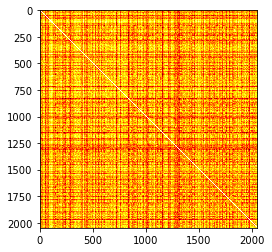

In [153]:
plt.imshow(mat, cmap='hot', interpolation='nearest')

In [154]:
dia = np.diag_indices(vector_len)
dia_sum = sum(mat[dia])
off_dia_sum = np.sum(mat) - dia_sum
print(off_dia_sum / (vector_len**2 - vector_len))

0.6127001189762648


## Saving the Embeddings

In [159]:
array_vector_embeddings.shape

(101, 2048)

In [161]:
save_path = index.DIR_SCH / 'abstract_discs_embedded/'
if not save_path.exists():
    save_path.mkdir()

In [170]:
for arr, path in zip(array_vector_embeddings, paths_fractals):
    np.save(str(save_path / path.stem), arr)